In [33]:
from fastai.vision.all import *

In [2]:
def load_data(folder):
    path = untar_data(URLs.MNIST_SAMPLE)
    threes = [tensor(Image.open(o)) for o in (path / f"{folder}" / '3').ls().sorted()]
    sevens = [tensor(Image.open(o)) for o in (path / f"{folder}" / '7').ls().sorted()]
    stacked_threes = torch.stack(threes).float() / 255.
    stacked_sevens = torch.stack(sevens).float() / 255.
    x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
    y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(-1)
    dset = list(zip(x, y))
    return DataLoader(dset, batch_size=64, shuffle=True)


In [3]:
train_dl = load_data('train')
valid_dl = load_data('valid')

In [4]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

def linear1(xb):
    return xb@weights + bias

def mnist_loss(yhat, yb):
    yhat = yhat.sigmoid()
    return torch.where((yb==1), 1-yhat, yhat).mean()

def calc_grad(xb, yb, model):
    yhat = model(xb)
    loss = mnist_loss(yhat, yb)
    loss.backward()
    
def train_epoch(train_dl):
    for xb, yb in train_dl:
        calc_grad(xb, yb, linear1)
        for p in params:
            p.data -= p.grad * lr
            p.grad = None
            
def valid_acc(yhat, yb):
    yhat = yhat.sigmoid()
    return ((yhat >= 0.5) == yb).float().mean()
            
def valid_epoch(valid_dl):
    accs = [valid_acc(linear1(xb), yb) for xb, yb in valid_dl]
    return round(tensor(accs).mean().item(), 4)
        

In [5]:
lr = 0.1
weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias

for i in range(20):
    train_epoch(train_dl)
    print(valid_epoch(valid_dl), end=' ')

0.4729 0.7202 0.8733 0.904 0.9238 0.9317 0.938 0.9428 0.9454 0.9485 0.9506 0.9524 0.9534 0.9549 0.9558 0.9568 0.957 0.9578 0.959 0.9588 

In [6]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params:
            p.grad = None
            
def train_epoch2(train_dl):
    for xb, yb in train_dl:
        calc_grad(xb, yb, linear1)
        opt.step()
        opt.zero_grad()
        
def train_model(epochs):
    for epoch in range(epochs):
        train_epoch2(train_dl)
        print(valid_epoch(valid_dl), end=' ')

In [7]:
lr = 0.1
weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias
opt = BasicOptim(params, lr)
train_model(20)

0.734 0.8676 0.9062 0.9293 0.9389 0.9459 0.9495 0.9523 0.9556 0.9578 0.9581 0.9606 0.9609 0.9628 0.9636 0.9639 0.9642 0.9643 0.9658 0.9662 

In [32]:
simple_model = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)
dls = DataLoaders(train_dl, valid_dl)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

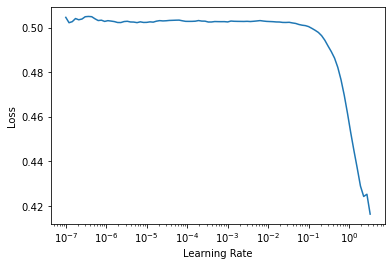

In [27]:
learn = Learner(dls, simple_model, loss_func=mnist_loss, opt_func=SGD, metrics=valid_acc)
learn.lr_find()

In [12]:
learn.fit_one_cycle(20, 3e-1)

epoch,train_loss,valid_loss,valid_acc,time
0,0.210749,0.109272,0.965162,00:00
1,0.048673,0.040522,0.971050,00:00
2,0.027516,0.029377,0.976448,00:00
3,0.022000,0.024422,0.979882,00:00
4,0.018022,0.021298,0.981845,00:00
5,0.017542,0.021511,0.981354,00:00
6,0.013576,0.018596,0.984298,00:00
7,0.015253,0.018720,0.982826,00:00
8,0.013009,0.017651,0.985770,00:00
9,0.013538,0.017617,0.984789,00:00


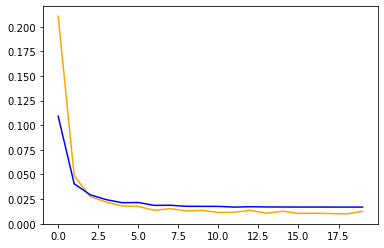

In [13]:
plt.plot(tensor(learn.recorder.values)[:,0], color='orange')
plt.plot(tensor(learn.recorder.values)[:,1], color='blue')